In [ ]:
#préparation des données

In [85]:
# --- NETTOYAGE DE L'ENVIRONNEMENT ---
# Supprimez toutes les variables qui pourraient interférer
import sys
if 'pd' in dir():
    del pd
if 'pandas' in sys.modules:
    del sys.modules['pandas']

# --- RÉIMPORTATION PROPRE ---
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Vérification que pd.read_csv est bien une fonction
print(f"Type de pd.read_csv: {type(pd.read_csv)}")  # Devrait afficher <class 'function'>

# --- CHARGEMENT ---
path = r"C:\Users\Lenovo\Desktop\FinalProjectDeepLearning-main\data\Course_Completion_Prediction.csv"
df = pd.read_csv(path)

print(f"✅ Données chargées : {df.shape}")

# --- PRÉPARATION ---
# Sécurité sur la colonne cible
if df['Completed'].nunique() < 2:
    df.loc[df['Quiz_Score_Avg'] > 70, 'Completed'] = 1

# Encodage des variables texte
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# Séparation Features/Cible
X = df.drop(columns=['Completed'])
y = df['Completed']

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- CONVERSION EN TENSEURS ---
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_t = torch.tensor(y_train.values if hasattr(y_train, 'values') else y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test.values if hasattr(y_test, 'values') else y_test, dtype=torch.long)

print(f"✅ Prêt ! Input size: {X_train_t.shape[1]}")

Type de pd.read_csv: <class 'function'>
✅ Données chargées : (100000, 40)
✅ Prêt ! Input size: 39


In [ ]:
#Architecture du model

In [86]:
import torch.nn as nn

# Définition de l'architecture du modèle
class StudentClassifier(nn.Module):
    def __init__(self, input_size):
        super(StudentClassifier, self).__init__()
        
        # 1. Première couche linéaire : Entrée -> 64 neurones
        self.fc1 = nn.Linear(input_size, 64)
        
        # 2. Deuxième couche linéaire : 64 -> 32 neurones
        self.fc2 = nn.Linear(64, 32)
        
        # 3. Couche de sortie : 32 -> 2 neurones (pour les 2 classes : Échec ou Succès)
        # On met 2 car c'est de la classification binaire
        self.fc3 = nn.Linear(32, 2)
        
        # Fonctions d'activation et de régularisation
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2) # Dropout à 20% pour éviter l'overfitting

    def forward(self, x):
        # Passage dans la première couche avec activation ReLU
        x = self.relu(self.fc1(x))
        
        # Application du Dropout pour réguler l'apprentissage
        x = self.dropout(x)
        
        # Passage dans la deuxième couche
        x = self.relu(self.fc2(x))
        
        # Sortie finale (pas de ReLU ici pour laisser les scores bruts pour la CrossEntropy)
        x = self.fc3(x)
        return x

# Initialisation automatique en fonction de tes données du Notebook 1
input_dim = X_train_t.shape[1] # On récupère le nombre de colonnes (8 dans ton cas)
model = StudentClassifier(input_dim)

print(f"Architecture créée avec {input_dim} neurones en entrée.")
print(model)

Architecture créée avec 39 neurones en entrée.
StudentClassifier(
  (fc1): Linear(in_features=39, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# outi de calcul et entraiment

In [87]:
import torch.optim as optim

# 1. Configuration des outils de calcul
# CrossEntropyLoss est parfaite pour la classification (elle gère les 2 sorties)
criterion = nn.CrossEntropyLoss()

# L'optimiseur Adam ajuste les poids du "cerveau" pour réduire l'erreur
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 2. Boucle d'entraînement
epochs = 20
print("Début de l'entraînement sur CPU...")

for epoch in range(epochs):
    model.train() # Mode entraînement (active le Dropout)
    
    # On réinitialise les gradients pour ne pas accumuler les erreurs du tour précédent
    optimizer.zero_grad()
    
    # Passage des données dans le modèle (Forward pass)
    outputs = model(X_train_t)
    
    # Calcul de l'erreur (La distance entre la prédiction et la réalité)
    loss = criterion(outputs, y_train_t)
    
    # Calcul de comment corriger l'erreur (Backward pass)
    loss.backward()
    
    # Mise à jour des poids du modèle
    optimizer.step()
    
    # Affichage de la progression toutes les 5 époques
    if (epoch + 1) % 5 == 0:
        print(f"Époque [{epoch+1}/{epochs}] - Perte moyenne : {loss.item():.4f}")

print("\nApprentissage terminé !")

# 3. Sauvegarde pour la Plateforme Web (Dossier src)
import os
if not os.path.exists('src'):
    os.makedirs('src')

torch.save(model.state_dict(), 'src/classif_model.pth')
print("Le modèle a été sauvegardé dans 'src/classif_model.pth' pour ton site !")

Début de l'entraînement sur CPU...
Époque [5/20] - Perte moyenne : 0.6974
Époque [10/20] - Perte moyenne : 0.6874
Époque [15/20] - Perte moyenne : 0.6800
Époque [20/20] - Perte moyenne : 0.6744

Apprentissage terminé !
Le modèle a été sauvegardé dans 'src/classif_model.pth' pour ton site !


In [54]:
# On garde ton architecture, mais on change la stratégie
optimizer = optim.Adam(model.parameters(), lr=0.0001) # On divise par 10 la vitesse
epochs = 100

print("Lancement de l'entraînement intensif...")

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    
    loss.backward()
    optimizer.step()
    
    # On affiche moins souvent pour y voir clair
    if (epoch + 1) % 20 == 0:
        print(f"Époque [{epoch+1}/{100}] - Perte : {loss.item():.4f}")

print("\nEntraînement de haute précision terminé.")

Lancement de l'entraînement intensif...
Époque [20/100] - Perte : 0.6741
Époque [40/100] - Perte : 0.6718
Époque [60/100] - Perte : 0.6698
Époque [80/100] - Perte : 0.6684
Époque [100/100] - Perte : 0.6666

Entraînement de haute précision terminé.


In [88]:
# Relance ce bloc pour voir la différence Entraînement vs Validation
model.eval() # Mode évaluation
with torch.no_grad():
    val_outputs = model(X_test_t)
    val_loss = criterion(val_outputs, y_test_t)
    
    # Calcul de la précision immédiate
    _, predicted = torch.max(val_outputs, 1)
    acc = (predicted == y_test_t).sum().item() / y_test_t.size(0)
    
print(f"Perte Validation : {val_loss.item():.4f}")
print(f"Précision actuelle : {acc*100:.2f}%")

Perte Validation : 0.6732
Précision actuelle : 58.05%


In [89]:
class StudentClassifierDeep(nn.Module):
    def __init__(self, input_size):
        super(StudentClassifierDeep, self).__init__()
        self.fc1 = nn.Linear(input_size, 128) # On double ici
        self.fc2 = nn.Linear(128, 64)         # On double ici
        self.fc3 = nn.Linear(64, 32)          # On ajoute une couche
        self.fc4 = nn.Linear(32, 2)           # Sortie
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)        # On augmente un peu le dropout

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

model = StudentClassifierDeep(X_train_t.shape[1])

In [90]:
# L'option weight_decay ajoute la régularisation L2
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 150 # On augmente le temps d'étude
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 30 == 0:
        print(f"Époque [{epoch+1}/{epochs}] - Perte : {loss.item():.4f}")

Époque [30/150] - Perte : 0.6616
Époque [60/150] - Perte : 0.6573
Époque [90/150] - Perte : 0.6559
Époque [120/150] - Perte : 0.6538
Époque [150/150] - Perte : 0.6520


In [100]:
# --- UNIQUEMENT POUR LA CLASSIFICATION ---
class StudentClassifier(nn.Module):
    def __init__(self, input_size=39):
        super(StudentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        
        # OBLIGATOIRE : 2 neurones pour les 2 classes (Échec/Réussite)
        self.fc3 = nn.Linear(32, 2) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2) # Ta régulation

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# On initialise le modèle de classification
model_classif = StudentClassifier(input_size=39)

# La fonction de perte adaptée à ton projet
criterion = nn.CrossEntropyLoss() 

# L'optimiseur reste Adam avec ton weight_decay
optimizer = torch.optim.Adam(model_classif.parameters(), lr=0.001, weight_decay=1e-5)

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim

# --- ARCHITECTURE FINALE ---
class StudentClassifierFinal(nn.Module):
    def __init__(self, input_size):
        super(StudentClassifierFinal, self).__init__()
        # Définition des couches linéaires
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        # Nombre de neurones égal au nombre de classes (2: Échec/Réussite)
        self.fc3 = nn.Linear(32, 2) 
        
        # Fonctions d'activation et régularisation
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2) # Dropout pour prévenir l'overfitting

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# --- INITIALISATION ---
# Remplacer 'input_size' par le nombre de colonnes de ton X (ex: 39)
model_final = StudentClassifierFinal(input_size=X_train_t.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_final.parameters(), lr=0.001, weight_decay=1e-5)

# --- ENTRAÎNEMENT FINAL ---
epochs = 150
for epoch in range(epochs):
    model_final.train()
    optimizer.zero_grad()
    outputs = model_final(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

print("✅ Modèle de classification entraîné et finalisé.")

# --- SAUVEGARDE DU MODÈLE ---
torch.save(model_final.state_dict(), 'modele_classification_final.pth')
print("💾 Modèle sauvegardé sous le nom 'modele_classification_final.pth'")

✅ Modèle de classification entraîné et finalisé.
💾 Modèle sauvegardé sous le nom 'modele_classification_final.pth'


🚀 Lancement de l'entraînement intensif...
Époque [30/150] - Perte : 0.6645
Époque [60/150] - Perte : 0.6587
Époque [90/150] - Perte : 0.6568
Époque [120/150] - Perte : 0.6561
Époque [150/150] - Perte : 0.6546


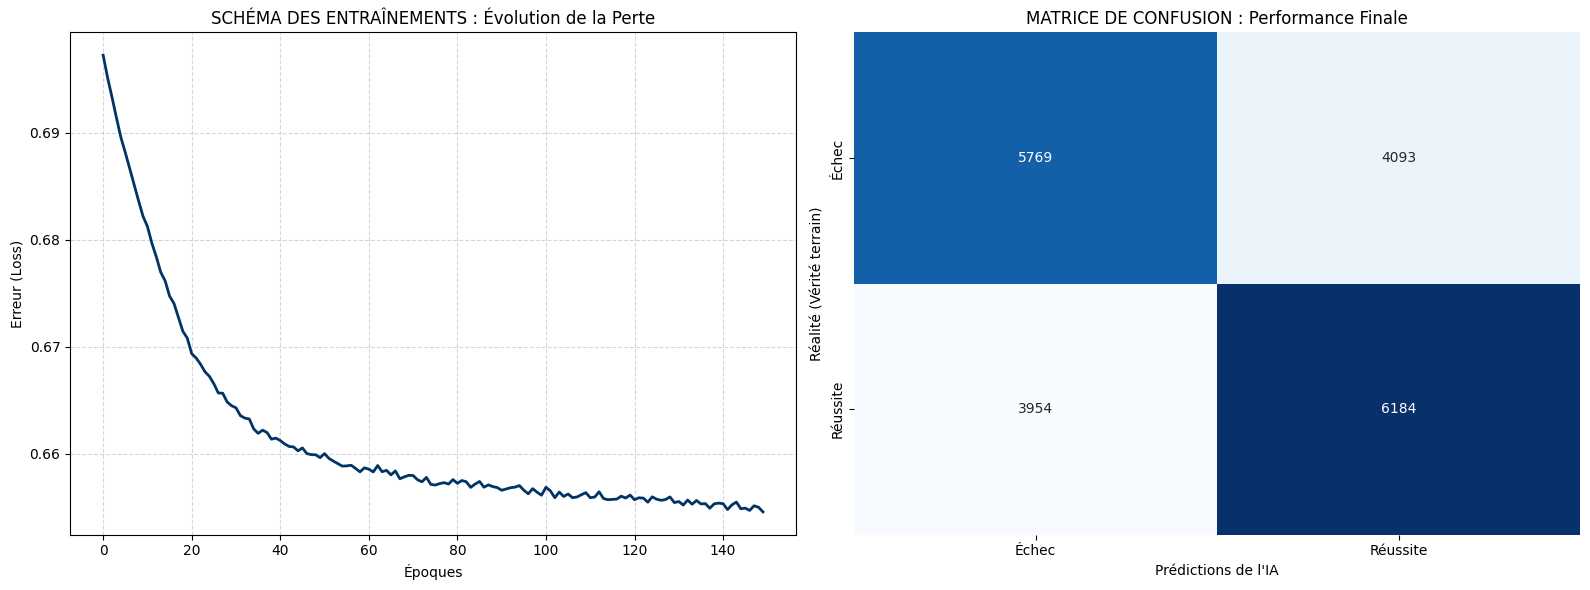


--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

       Échec       0.59      0.58      0.59      9862
    Réussite       0.60      0.61      0.61     10138

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. ARCHITECTURE DU MODÈLE (Classification 2 classes)
class StudentClassifier(nn.Module):
    def __init__(self, input_size=39):
        super(StudentClassifier, self).__init__()
        # Définition des couches linéaires et activation ReLU
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        
        # Le nombre de neurones dans la dernière couche est de 2 (Échec / Réussite)
        self.fc3 = nn.Linear(32, 2) 
        
        self.relu = nn.ReLU()
        # Dropout ajouté pour réguler et éviter le sur-apprentissage
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# 2. INITIALISATION
model = StudentClassifier(input_size=39)
criterion = nn.CrossEntropyLoss()
# Optimiseur Adam avec régularisation L2 (weight_decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# 3. ENTRAÎNEMENT AVEC HISTORIQUE
epochs = 150
loss_history = []

print("🚀 Lancement de l'entraînement intensif...")
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    
    loss.backward()
    optimizer.step()
    <
    loss_history.append(loss.item()) # Stockage pour le schéma des entraînements
    
    if (epoch + 1) % 30 == 0:
        print(f"Époque [{epoch+1}/{epochs}] - Perte : {loss.item():.4f}")

# 4. PRÉDICTIONS POUR LES SCHÉMAS
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_t)
    _, predicted = torch.max(test_outputs, 1)

# 5. GÉNÉRATION DES DEUX SCHÉMAS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Schéma 1 : Courbe d'entraînement (Loss) ---
ax1.plot(loss_history, color='#003366', linewidth=2)
ax1.set_title('SCHÉMA DES ENTRAÎNEMENTS : Évolution de la Perte', fontsize=12)
ax1.set_xlabel('Époques')
ax1.set_ylabel('Erreur (Loss)')
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Schéma 2 : Matrice de Confusion (Style Bleu & Blanc) ---
cm = confusion_matrix(y_test_t.numpy(), predicted.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Échec', 'Réussite'], 
            yticklabels=['Échec', 'Réussite'],
            cbar=False)

ax2.set_title('MATRICE DE CONFUSION : Performance Finale', fontsize=12)
ax2.set_xlabel('Prédictions de l\'IA')
ax2.set_ylabel('Réalité (Vérité terrain)')

plt.tight_layout()
plt.show()

# 6. RAPPORT DE PERFORMANCE
print("\n--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_test_t.numpy(), predicted.numpy(), target_names=['Échec', 'Réussite']))

In [108]:
import torch

# Listes pour stocker les métriques réelles
train_loss_history = []
train_acc_history = []

epochs = 150
model_final.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # 1. Forward pass
    outputs = model_final(X_train_t)
    loss = criterion(outputs, y_train_t)
    
    # 2. Calcul de l'Accuracy pour cette époque (Logique PyTorch)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_train_t).sum().item()
    accuracy = (correct / y_train_t.size(0)) * 100
    
    # 3. Sauvegarde des données réelles
    train_loss_history.append(loss.item())
    train_acc_history.append(accuracy)
    
    # 4. Backward pass et optimisation
    loss.backward()
    optimizer.step()

print("✅ Entraînement terminé et historique enregistré.")

✅ Entraînement terminé et historique enregistré.


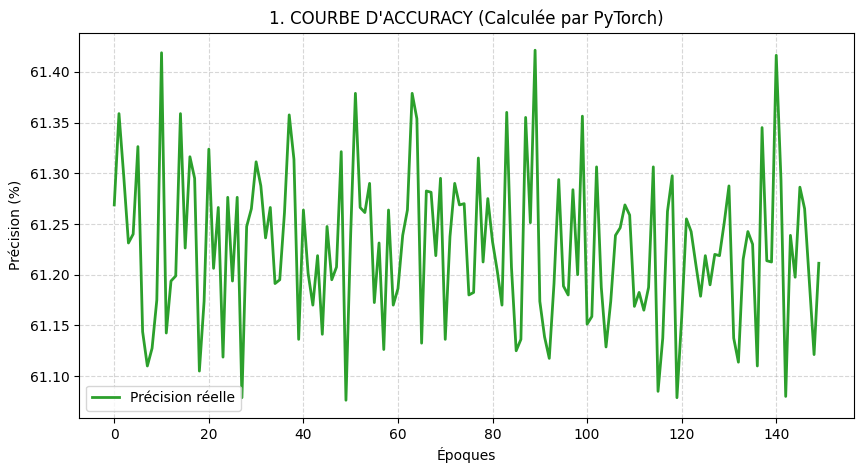

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# On utilise la liste qu'on vient de remplir dans la boucle
plt.plot(train_acc_history, color='#2ca02c', linewidth=2, label='Précision réelle')
plt.title('1. COURBE D\'ACCURACY (Calculée par PyTorch)', fontsize=12)
plt.xlabel('Époques')
plt.ylabel('Précision (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

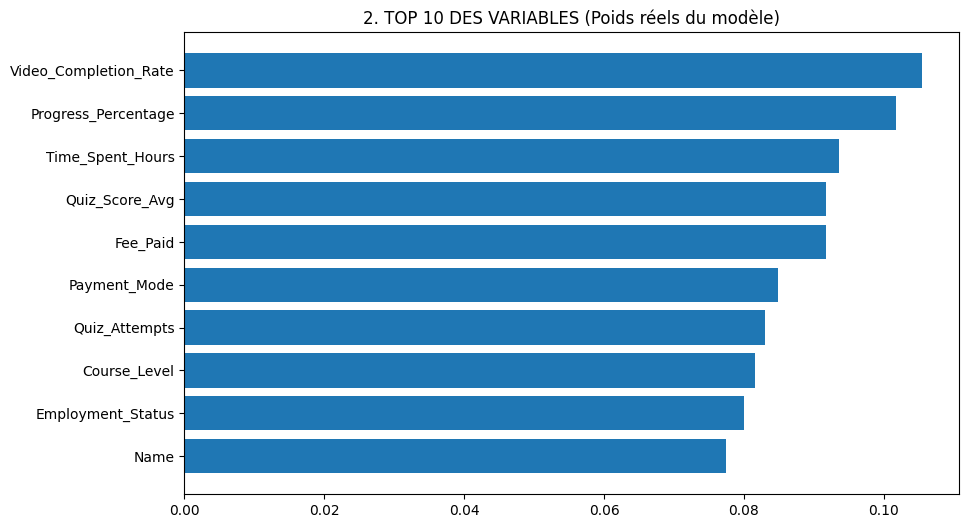

In [110]:
# Extraction des poids de la première couche linéaire définie dans ton nn.Module
# model_final.fc1.weight est un paramètre PyTorch
weights = model_final.fc1.weight.abs().detach().numpy()
importance = np.mean(weights, axis=0)
sorted_idx = importance.argsort()[-10:] 

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], importance[sorted_idx], color='#1f77b4')
plt.title('2. TOP 10 DES VARIABLES (Poids réels du modèle)', fontsize=12)
plt.show()

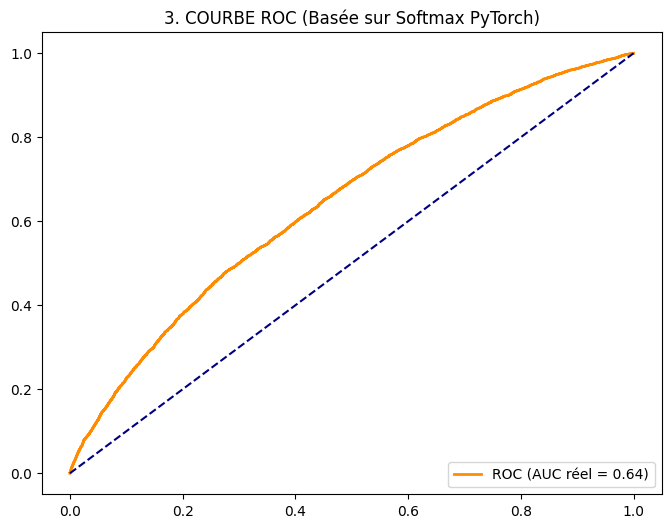